In [30]:
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
from shapely.geometry import shape, Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import folium
from folium.plugins import HeatMap
import contextily as ctx
import plotly.express as px
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

### Connecting to CA Geologic map to identify the rock type that each well sits on

[Data from this map](https://maps-cadoc.opendata.arcgis.com/maps/9eba56d981df4f839769ce9a2adc01f4/explore)

In [2]:
def identify_geology(lat, lon):
    identify_url = (
        "https://gis.conservation.ca.gov/server/rest/services/"
        "CGS/Geologic_Map_of_California/MapServer/identify"
    )
    
    params = {
        "f": "json",
        "geometry": f"{lon},{lat}",
        "geometryType": "esriGeometryPoint",
        "sr": "4326",
        "mapExtent": f"{lon-0.01},{lat-0.01},{lon+0.01},{lat+0.01}",
        "imageDisplay": "800,600,96",
        "tolerance": 1,
        "returnGeometry": "false",
        "layers": "all",
    }
    
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
        )
    }
    
    try:
        response = requests.get(identify_url, params=params, headers=headers)
        response.raise_for_status()
        data = response.json()
        return data.get("results", [])
    
    except Exception as e:
        print(f"Error querying service: {e}")
        return None

# trying it on a random point in CA to see what the response looks like
if __name__ == "__main__":
    lat = 34.0522
    lon = -118.2437
    
    results = identify_geology(lat, lon)
    if results:
        print("Number of results:", len(results))
        for r in results:
            print(r)


Number of results: 1
{'layerId': 12, 'layerName': 'Generalized Rock Types', 'displayFieldName': 'PTYPE', 'value': 'Q', 'attributes': {'OBJECTID': '13872', 'PTYPE': 'Q', 'GENERAL_LITHOLOGY': 'marine and nonmarine (continental) sedimentary rocks', 'AGE': 'Pleistocene-Holocene', 'DESCRIPTION': 'Alluvium, lake, playa, and terrace deposits; unconsolidated and semi-consolidated. Mostly nonmarine, but includes marine deposits near the coast.', 'SHAPE': 'Polygon', 'SHAPE.STArea()': '3942876694.487556', 'SHAPE.STLength()': '1860311.283161'}}


### Hooking back into CA DWR wells to map rock type to depths

Getting station IDs and performing geologic mapping top stage.

In [69]:
url = "https://data.cnra.ca.gov/api/3/action/datastore_search"
params = {
    "resource_id": "af157380-fb42-4abf-b72a-6f9f98868077",
    "limit": 100000,
    "offset": 0
}
response = requests.get(url, params=params)
data = response.json()['result']['records']
station_mapping = pd.DataFrame(data)
station_depth = station_mapping[~station_mapping.well_depth.isna()].copy()# approx 15k stations

In [4]:
def station_geologic(row):
    lat = row.latitude
    lon = row.longitude
    geology = identify_geology(lat, lon)
    rock_type = [item for item in geology if item["layerId"] == 12]
    if len(rock_type) > 1:
        print(f"Point has multiple geology: {len(rock_type)}")
    elif len(rock_type) == 0:
        return []
    try:
        return [rock["attributes"]["PTYPE"] for rock in rock_type]
    except KeyError:
        print(f"Warning: no geology found at {lat}, {lon} !")
        return None

In [5]:
'''
deprecated, method gets disconnected from geology server

rocks = []
for idx, row in tqdm(station_depth.iterrows(), total=len(station_depth)):
    val = station_geologic(row)
    rocks.append(val)
    '''

'\ndeprecated, method gets disconnected from geology server\n\nrocks = []\nfor idx, row in tqdm(station_depth.iterrows(), total=len(station_depth)):\n    val = station_geologic(row)\n    rocks.append(val)\n    '

In [52]:
def get_geologic_polygons(url):
    """
    Fetches the GeoJSON data from the given URL and returns a list of (shapely_geometry, properties).
    Each item in the returned list is a tuple of (Polygon/MultiPolygon, attribute_dictionary).
    """
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
        )
    }

    polygons = []
    offset = 0
    limit = 2000  # Adjust this based on the server's limit

    while True:
        print(f"Fetching data from: {url} with offset {offset}")
        paginated_url = f"{url}&resultRecordCount={limit}&resultOffset={offset}"
        response = requests.get(paginated_url, headers=headers)
        response.raise_for_status()
        
        geojson_data = response.json()
        features = geojson_data.get('features', [])
        
        if not features:
            break  # No more features to fetch
        
        for feature in features:
            geometry = shape(feature['geometry'])
            polygons.append((geometry, feature['properties']))
        
        offset += limit
    
    return polygons

def find_rock_type_for_points(points, polygons):
    """
    Given a list of (lon, lat) points and a list of (shapely_geometry, properties),
    returns a dict mapping each (lon, lat) point to a list of PTYPE values from the polygons it falls in.
    
    If a point does not fall in any polygon, it will map to an empty list.
    """
    results = {}
    
    for lon, lat in tqdm(points):
        point = Point(lon, lat)
        ptypes = []  # List to store all PTYPE values for the point
        
        # Check each polygon to see if the point is contained in it
        for polygon, props in polygons:
            if polygon.contains(point):
                ptype = props.get("PTYPE")  # Get the PTYPE value from the properties
                if ptype:
                    ptypes.append(ptype)
        
        # Ensure every point is included in the results, even if it has no PTYPE values
        results[(lon, lat)] = ptypes
    
    return results

url = (
        "https://gis.conservation.ca.gov/server/rest/services/CGS/"
        "Geologic_Map_of_California/MapServer/12/query"
        "?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson"
    )
    
# Fetch polygons
polygons_data = get_geologic_polygons(url)
print(f"Total polygons fetched: {len(polygons_data)}")

Fetching data from: https://gis.conservation.ca.gov/server/rest/services/CGS/Geologic_Map_of_California/MapServer/12/query?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson with offset 0
Fetching data from: https://gis.conservation.ca.gov/server/rest/services/CGS/Geologic_Map_of_California/MapServer/12/query?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson with offset 2000
Fetching data from: https://gis.conservation.ca.gov/server/rest/services/CGS/Geologic_Map_of_California/MapServer/12/query?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson with offset 4000
Fetching data from: https://gis.conservation.ca.gov/server/rest/services/CGS/Geologic_Map_of_California/MapServer/12/query?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson with offset 6000
Fetching data from: https://gis.conservation.ca.gov/server/rest/services/CGS/Geologic_Map_of_California/MapServer/12/query?where=1=1&outFields=*&returnGeometry=true&outSR=4326&f=geojson with 

In [49]:
wells = [(i,j) for i,j in zip(station_depth.longitude, station_depth.latitude)]
geologies = find_rock_type_for_points(wells, polygons_data)

100%|██████████| 14563/14563 [16:32<00:00, 14.67it/s]


In [56]:
def find_row_geology(row):
    lat = row.latitude
    lon = row.longitude
    return geologies[(lon,lat)]

In [67]:
station_depth.apply(find_row_geology, axis=1).apply(lambda x: len(x) == 0).sum()

18

In [70]:
station_depth["geology"] = station_depth.apply(find_row_geology, axis=1)

In [2]:
#station_depth.to_csv("stations_depth_geology.csv", index=False)

In [3]:
station_depth = pd.read_csv("../Data/stations_depth_geology.csv")
station_depth['geology'] = station_depth['geology'].apply(ast.literal_eval)
station_depth = station_depth[station_depth['geology'].apply(lambda x: len(x) > 0)]

In [4]:
station_depth = station_depth.explode("geology")

In [5]:
station_depth.geology.value_counts()

geology
Q        11275
Qoa       1447
QPc        942
Qs         209
P          126
grMz        86
Tv          85
M           72
Mc          40
Qg          38
Tvp         37
water       29
Qv          27
KJf         19
Qv?         14
Ec          13
J           11
Oc          10
Pz           9
Qrv          7
um           6
Ku           6
E            6
Mzv          5
pCc          4
TK           3
Tc           3
gb           3
Qvp          2
KJfm         2
KJfs         2
Ku-Ep        2
Kl           1
pC           1
gr-m         1
m            1
Ti           1
Name: count, dtype: int64

In [13]:
geometry = [Point(xy) for xy in zip(station_depth['longitude'], station_depth['latitude'])]
gdf = gpd.GeoDataFrame(station_depth, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")  # Reproject to a CRS that uses meters

In [14]:
radius = 10 * 1609.34

def calculate_average_well_depth(point, gdf, radius):
    nearby_points = gdf[gdf.geometry.within(point.buffer(radius))]
    if len(nearby_points) > 0:
        return nearby_points['well_depth'].mean()
    else:
        return np.nan

In [15]:
gdf['average_well_depth'] = gdf.apply(lambda row: calculate_average_well_depth(row['geometry'], gdf, radius), axis=1)

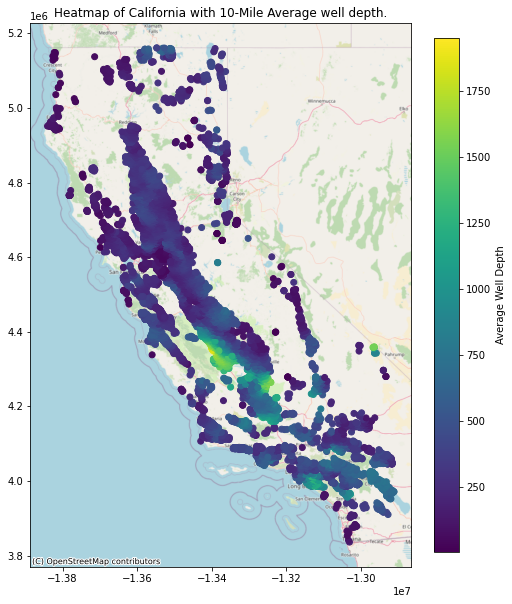

In [24]:
norm = plt.Normalize(vmin=gdf['average_well_depth'].min(), vmax=gdf['average_well_depth'].max())

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='average_well_depth', cmap="viridis", norm=norm, ax=ax, legend=False)  # Disable automatic legend
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Heatmap of California with 10-Mile Average well depth.")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Average Well Depth')

plt.show()

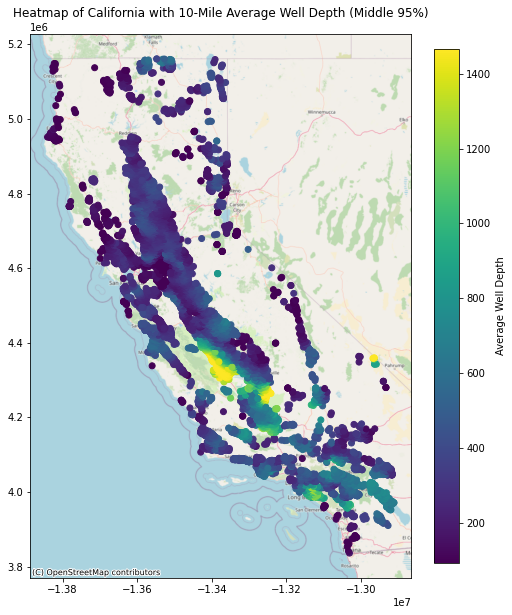

In [26]:
vmin = gdf['average_well_depth'].quantile(0.025)
vmax = gdf['average_well_depth'].quantile(0.975)

norm = plt.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='average_well_depth', cmap="viridis", norm=norm, ax=ax, legend=False)  # Disable automatic legend

ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Heatmap of California with 10-Mile Average Well Depth (Middle 95%)")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Average Well Depth')

plt.show()

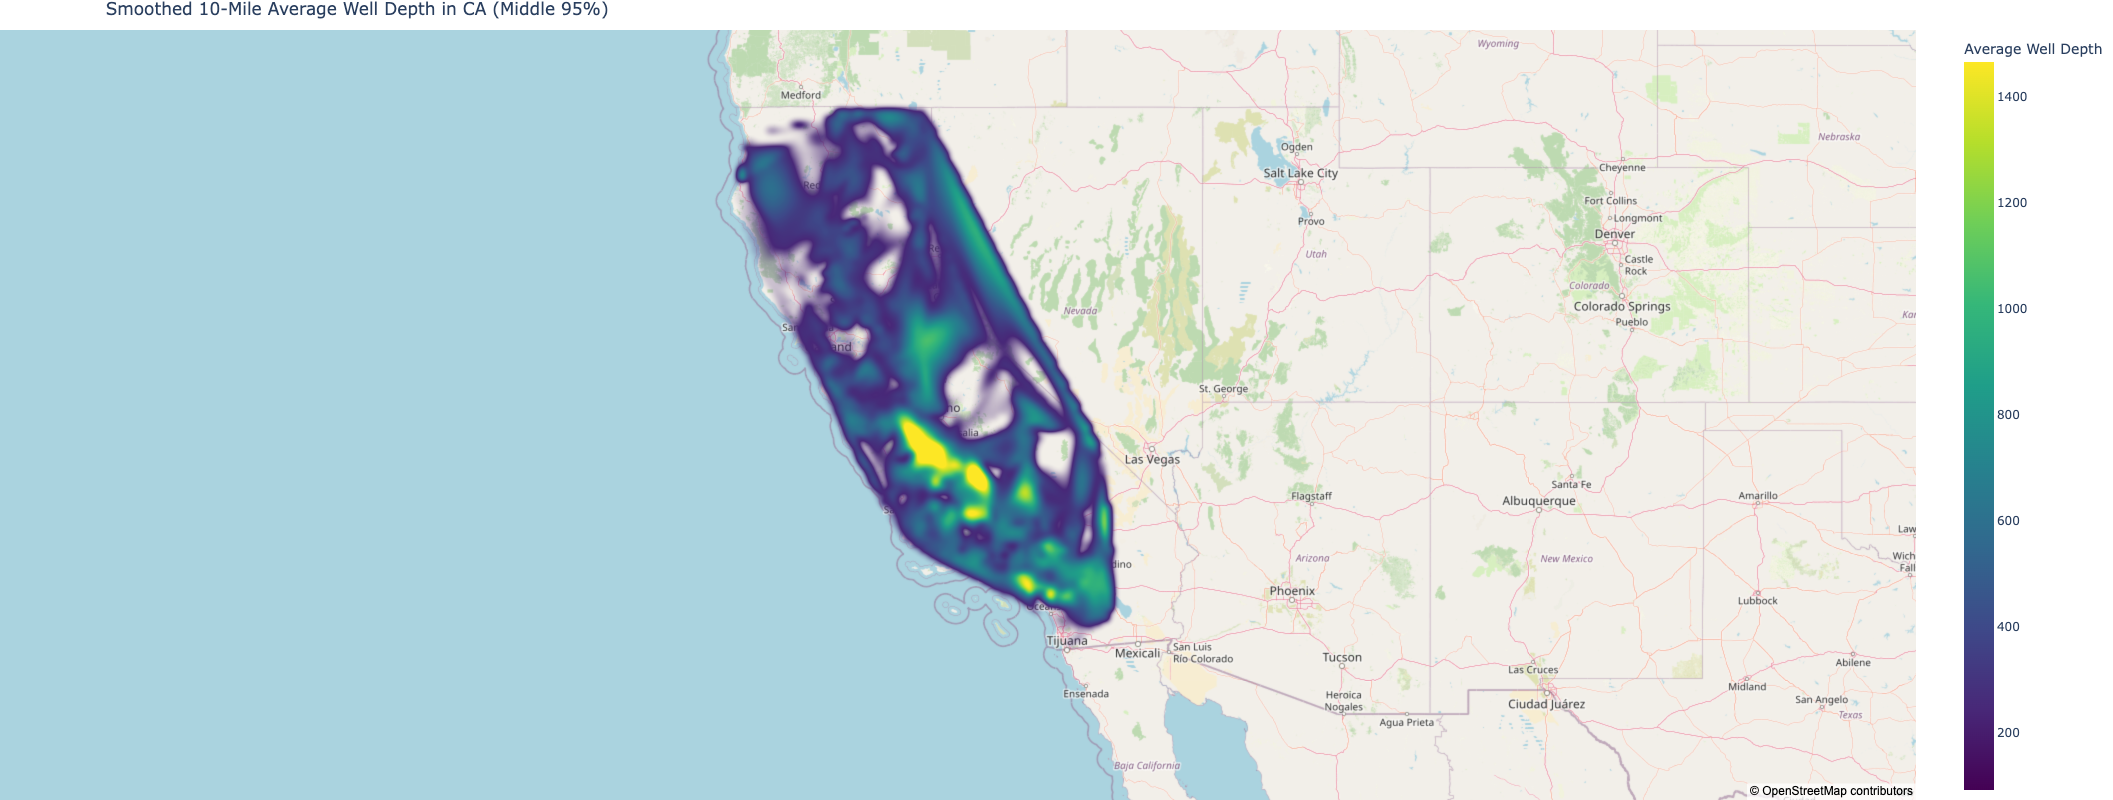

In [35]:
lat = gdf['latitude'].values
lon = gdf['longitude'].values
depth = gdf['average_well_depth'].values

lower_percentile = np.percentile(depth, 2.5)
upper_percentile = np.percentile(depth, 97.5)

mask = (depth >= lower_percentile) & (depth <= upper_percentile)
lat_filtered = lat[mask]
lon_filtered = lon[mask]
depth_filtered = depth[mask]

grid_lat, grid_lon = np.mgrid[
    gdf['latitude'].min():gdf['latitude'].max():100j,  # 100 points in latitude
    gdf['longitude'].min():gdf['longitude'].max():100j  # 100 points in longitude
]

grid_depth = griddata(
    points=(lat_filtered, lon_filtered),  # Input points (latitude, longitude)
    values=depth_filtered,               # Values to interpolate (average well depth)
    xi=(grid_lat, grid_lon),             # Grid to interpolate onto
    method='cubic'                       # Interpolation method ('linear', 'nearest', or 'cubic')
)

interpolated_data = pd.DataFrame({
    'latitude': grid_lat.flatten(),
    'longitude': grid_lon.flatten(),
    'average_well_depth': grid_depth.flatten()
})

interpolated_data.dropna(inplace=True)

fig = px.density_mapbox(
    interpolated_data,
    lat='latitude',
    lon='longitude',
    z='average_well_depth',
    radius=10,
    zoom=5,
    center=dict(lat=36.7783, lon=-119.4179),
    mapbox_style='open-street-map',
    title='Smoothed 10-Mile Average Well Depth in CA (Middle 95%)',
    color_continuous_scale='viridis',
    range_color=(lower_percentile, upper_percentile)
)

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
    coloraxis_colorbar=dict(title='Average Well Depth'),
    width=800,
    height=800,
    mapbox=dict(
        center=dict(lat=36.7783, lon=-119.4179),
        zoom=5,
        style='open-street-map'
    )
)

fig.show()

In [36]:
gdf.to_file("station_depth_gdf.geojson", driver="GeoJSON")